In [173]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier, plot_tree, plot_importance

def seed_everything(seed:int=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

plt.rcParams['font.family'] = 'Malgun Gothic'
warnings.filterwarnings('ignore')
seed_everything()

In [174]:
df = pd.read_csv('./dataset/ff.csv')

def make_targets(targets):
    return 1 if targets >=5 else 0

df['BE3_31'] = df.apply(
    lambda row: make_targets(row['BE3_31']), axis=1
)
df['BE5_1'] = df.apply(
    lambda row: make_targets(row['BE5_1']), axis=1
)

df.head(3)

,HE_FEV1FVC,age,Total_slp_wk,sex,occp,EC1_1,cfam,marri_1,BH9_11,HE_DM,...,EC_pedu_1,EC_pedu_2,BS5_1,BD7_4,eq_5d,sm_present,mh_stress,cage,BE3_31,BE5_1
0,0.699366,74.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,NaN,NaN,비흡연자,없었음,0.720,1,1.0,7,1,0
1,0.698630,80.0,6.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,...,NaN,NaN,비흡연자,없었음,0.723,0,0.0,7,0,0
2,0.698466,49.0,8.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,무학,무학,언젠가금연,1년동안있었음,1.000,0,0.0,4,0,0


In [175]:
drops = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
display(drops)
df = df[drops[drops.values <= 10].index]

HE_cough1       23.867550
HE_sput1        23.867550
EC_pedu_1       23.682119
EC_pedu_2       20.503311
HE_DM           16.529801
BD7_4           15.072848
BD7_5           13.086093
BH9_11          11.735099
BP6_10          10.728477
BP5             10.622517
BH1             10.490066
BS5_1            4.582781
occp             1.748344
EC1_1            1.589404
edu              1.589404
LQ4_00           1.509934
LQ_4EQL          1.483444
LQ1_sb           1.456954
BH2_61           1.456954
LQ1_mn           1.456954
LQ_5EQL          1.456954
LQ_3EQL          1.456954
LQ_1EQL          1.456954
LQ_2EQL          1.456954
MO1_wk           1.430464
D_1_1            1.377483
BS6_3            0.158940
BS6_2_1          0.158940
marri_1          0.132450
BP1              0.105960
BS3_1            0.105960
mh_stress        0.105960
BO1_1            0.079470
cfam             0.079470
BO2_1            0.052980
BD1              0.026490
sm_present       0.000000
cage             0.000000
BE3_31      

In [176]:
# feature importance 기반 변수 제거(1차)
df.drop(['LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL'], axis=1, inplace=True)
# feature importance 기반 변수 제거(2차)
# df.drop(['BS5_1'], axis=1, inplace=True)

In [177]:
# 1차년도
NUMERIC = ['HE_FEV1FVC', 'age', 'Total_slp_wk']
CATEGORICAL = ['sex', 'occp', 'EC1_1', 'cfam', 'marri_1', 'BH9_11', 'HE_DM', 'DC6_dg', 'DF2_dg', 'HE_HPdg', 'BP5']
ONE_HOT = ['BS3_1', 'edu', 'BP1', 'D_1_1', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL', 'LQ_4EQL', 'LQ_5EQL', 'BO1_1', 'BO2_1']
# 2차년도
NUMERIC2 = ['DI1_ag', 'DE1_ag', 'LQ1_mn', 'BS6_2_1', 'BS6_3']
CATEGORICAL2 = ['DI1_pt', 'DE1_pt', 'DE1_3', 'BH1', 'BH2_61', 'LQ4_00', 'LQ4_05', 'LQ1_sb', 'MO1_wk', 'HE_cough1', 'HE_sput1', 'BD1', 'BD7_5', 'BP6_10', 'BP6_31']
ONE_HOT2 = ['DI1_2', 'EC_pedu_1', 'EC_pedu_2', 'BS5_1', 'BD7_4']
# 생성변수
NUMERIC3 = ['eq_5d']
CATEGORICAL3 = ['sm_present', 'mh_stress']
ONE_HOT3 = ['cage']
# Targets
TARGETS = ['BE3_31', 'BE5_1']

f_NUMERIC = (NUMERIC + NUMERIC2 + NUMERIC3).copy()
f_CATEGORICAL = (CATEGORICAL + CATEGORICAL2 + CATEGORICAL3).copy()
f_ONE_HOT = (ONE_HOT + ONE_HOT2 + ONE_HOT3).copy()

In [180]:
for value in f_NUMERIC:
    if value not in df.columns:
        print(value)
        f_NUMERIC.remove(value)

In [185]:
for value in f_CATEGORICAL:
    if value not in df.columns:
        print(value)
        f_CATEGORICAL.remove(value)

In [190]:
for value in f_ONE_HOT:
    if value not in df.columns:
        print(value)
        f_ONE_HOT.remove(value)

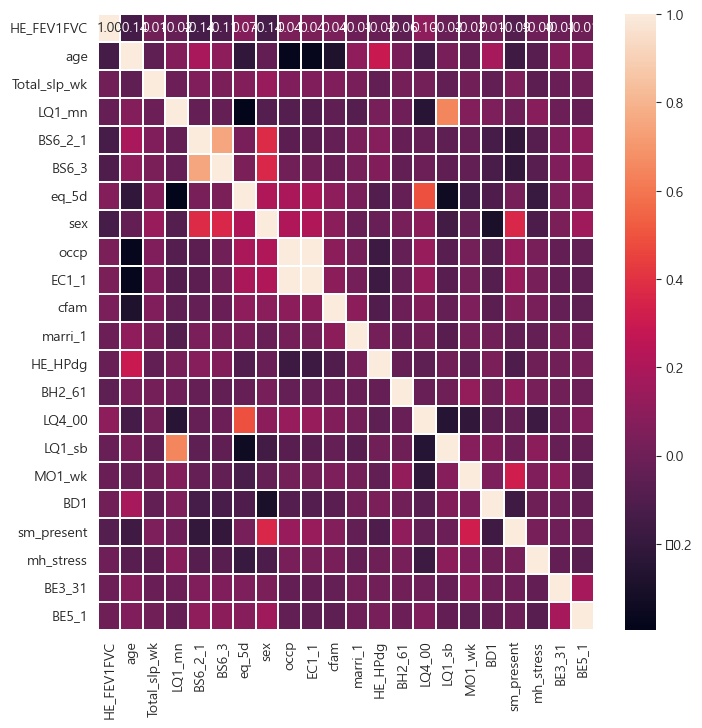

In [191]:
plt.figure(figsize=(8, 8))
sns.heatmap(df[f_NUMERIC + f_CATEGORICAL + TARGETS].corr(), annot=True, linewidths=.3, fmt='.2f')
plt.show()

In [192]:
f_CATEGORICAL.append('BE3_31')

In [193]:
# 결측치 처리
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [194]:
X = df.drop('BE5_1', axis=1)
y = df['BE5_1']

X_numeric = X[f_NUMERIC]
X_categorical = X[f_CATEGORICAL]
X_onehot = X[f_ONE_HOT]

In [195]:
# 원핫인코딩
X_onehot = pd.get_dummies(X_onehot, dtype=float)
X_onehot_cage = pd.get_dummies(X_onehot['cage'], dtype='float')
X_onehot.drop('cage', axis=1, inplace=True)
X_onehot = pd.concat([X_onehot, X_onehot_cage], axis=1)

In [196]:
X = pd.concat([X_numeric, X_categorical], axis=1)
X = pd.concat([X, X_onehot], axis=1)

In [197]:
# split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

train_X = train_X.reset_index().drop('index', axis=1)
train_y = train_y.reset_index().drop('index', axis=1)

In [205]:
adasyn = ADASYN(random_state=42)
ada_X, ada_y = adasyn.fit_resample(train_X.values, train_y)
ada_X = pd.DataFrame(ada_X, columns=train_X.columns)

In [212]:
# tuning
param_2 = {
    'n_estimators': 276, 
    'max_depth': 66, 
    'learning_rate': 0.009816392225839262, 
    'gamma': 9.709392373191752, 
    'alpha': 0.852347089015269, 
    'lambda': 9.832382625248556, 
    'min_child_weight': 5.9361686080930305, 
    'max_delta_step': 26, 
    'subsample': 0.5658032101992756, 
    'sampling_method': 'uniform', 
    'tree_method': 'approx', 
    'grow_policy': 'depthwise', 
    'max_bin': 282, 
    # 'scale_pos_weight': 8.09638554
}
model2 = XGBClassifier(objective='binary:logistic', device='cuda', random_state=42, **param_2)
# model2.fit(train_X, train_y)
model2.fit(ada_X, ada_y)

XGBClassifier(alpha=0.852347089015269, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=9.709392373191752, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=9.832382625248556, learning_rate=0.009816392225839262,
              max_bin=282, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=26, max_depth=66, max_leaves=None,
              min_child_weight=5.9361686080930305, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=276,
              n_jobs=None, ...)

In [214]:
print(classification_report(train_y, model2.predict(train_X)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2688
           1       0.58      0.18      0.27       332

    accuracy                           0.90      3020
   macro avg       0.75      0.58      0.61      3020
weighted avg       0.87      0.90      0.87      3020


In [138]:
print(classification_report(train_y, model2.predict(train_X)))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      2688
           1       0.34      0.81      0.48       332

    accuracy                           0.81      3020
   macro avg       0.66      0.81      0.68      3020
weighted avg       0.90      0.81      0.84      3020


In [139]:
print(classification_report(test_y, model2.predict(test_X)))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86       672
           1       0.27      0.65      0.38        83

    accuracy                           0.77       755
   macro avg       0.61      0.72      0.62       755
weighted avg       0.87      0.77      0.80       755


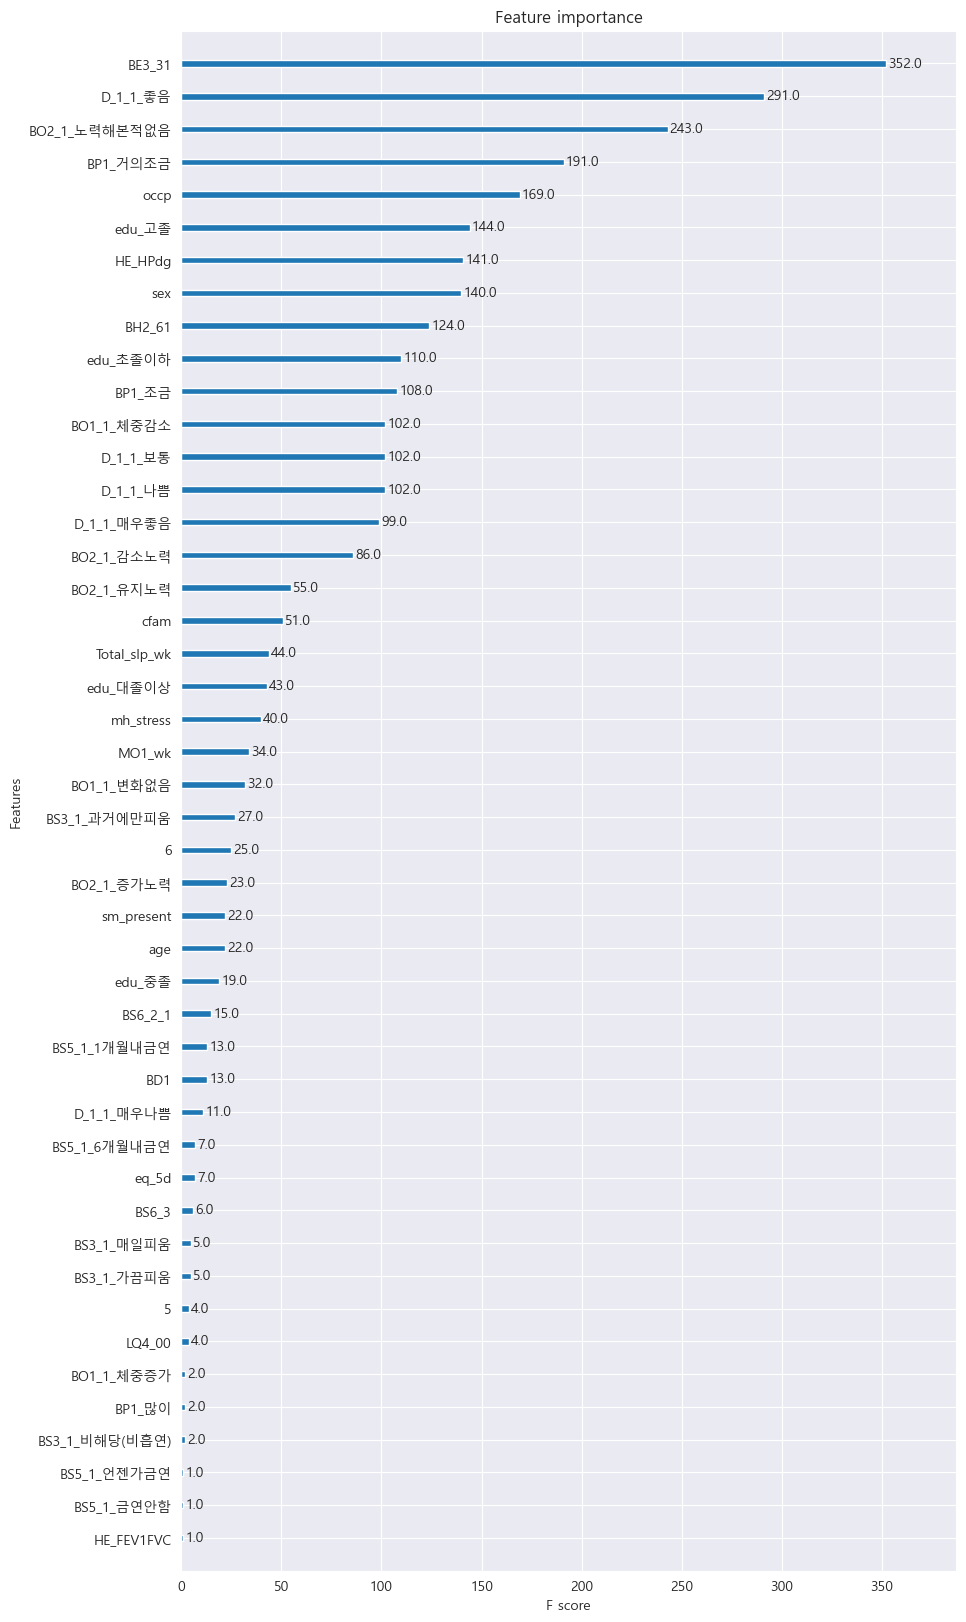

In [215]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_importance(model2, ax=ax)
plt.show()